# Question 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from typing import Tuple, Dict
import seaborn as sns
import os
import time
import math
from scipy.signal import find_peaks
import pandas as pd


In [5]:
# function to read the image
def load_document_image(file_path: str):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img is None:
        raise FileNotFoundError(f"Image file not found!!!")
    return img

# function to display the image
def display_image(img: np.ndarray, title: str):
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [35]:
# function to display the image details
def display_metadata(filepath: str):
    meta = {
        'image': {},
        'file':{},
        'color':{},
        'pixel_stats':{}
    }

    img = Image.open(filepath)

    # basic image details
    meta['image'] = {
        'format': img.format,
        'mode': img.mode,
        'size': img.size,
        'dimensions': f"{img.width} x {img.height}",
        'aspect_ratio': round(img.width/img.height,2),
    }

    # file details
    file_stats = os.stat(filepath)
    meta['file'] = {
        'file_size': f"{round(file_stats.st_size / (1024 * 1024), 2)} MB",
        'created': file_stats.st_ctime,
    }

    # color details
    colors = img.getcolors()
    meta['color'] = {
        'num_colors': len(colors),
        'colors': colors,
        'bands': img.getbands(),
        'bits_per_pixel': len(img.getbands()) * 8,
    }

    # Get pixel data statistics
    img_array = np.array(img)
    meta['pixel_stats'] = {
        'min': int(img_array.min()),
        'max': int(img_array.max()),
        'mean': round(float(img_array.mean()), 2),
        'std': round(float(img_array.std()), 2)
    }

    sections = ['image', 'file', 'color', 'pixel_stats']
    for section in sections:
        print(f"\n{'-'*20} {section.upper()} {'-'*20}")
        for key, value in meta[section].items():
            print(f"{key}: {value}")

def cv2_hist(image: np.ndarray):
    histogram = []
    for channel in range(3):
        hist = cv2.calcHist([image], [channel], None, [256], [0, 256])
        histogram.append(hist)
    
    plt.figure(figsize=(20, 5))
    plt.title("Histogram")

    plt.subplot(1, 3, 1)
    plt.xlabel("Intensity")
    plt.ylabel("Frequency")
    plt.plot(histogram[0], color='red', label='Red', alpha=0.75)
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.xlabel("Intensity")
    plt.ylabel("Frequency")
    plt.plot(histogram[1], color='green', label='Green', alpha=0.75)
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.xlabel("Intensity")
    plt.ylabel("Frequency")
    plt.plot(histogram[2], color='blue', label='Blue', alpha=0.75)
    plt.legend()
    plt.show()


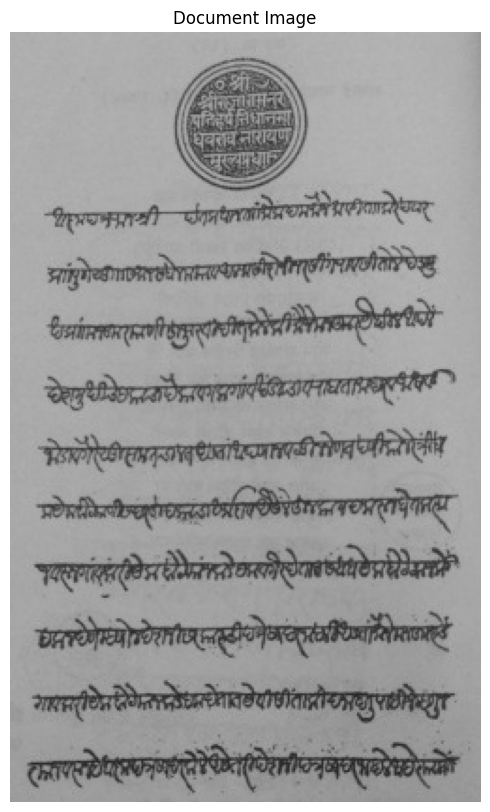


-------------------- IMAGE --------------------
format: PNG
mode: RGBA
size: (251, 411)
dimensions: 251 x 411
aspect_ratio: 0.61

-------------------- FILE --------------------
file_size: 0.1 MB
created: 1737492009.7346082

-------------------- COLOR --------------------
num_colors: 160
colors: [(1, (187, 187, 187, 255)), (4, (185, 185, 185, 255)), (15, (183, 183, 183, 255)), (171, (181, 181, 181, 255)), (1256, (179, 179, 179, 255)), (2144, (177, 177, 177, 255)), (3466, (175, 175, 175, 255)), (4363, (173, 173, 173, 255)), (3610, (171, 171, 171, 255)), (3164, (169, 169, 169, 255)), (3032, (167, 167, 167, 255)), (2955, (165, 165, 165, 255)), (2773, (163, 163, 163, 255)), (2482, (161, 161, 161, 255)), (2317, (159, 159, 159, 255)), (2265, (157, 157, 157, 255)), (1840, (155, 155, 155, 255)), (1588, (153, 153, 153, 255)), (1174, (151, 151, 151, 255)), (898, (149, 149, 149, 255)), (585, (147, 147, 147, 255)), (429, (145, 145, 145, 255)), (335, (143, 143, 143, 255)), (300, (141, 141, 141, 255

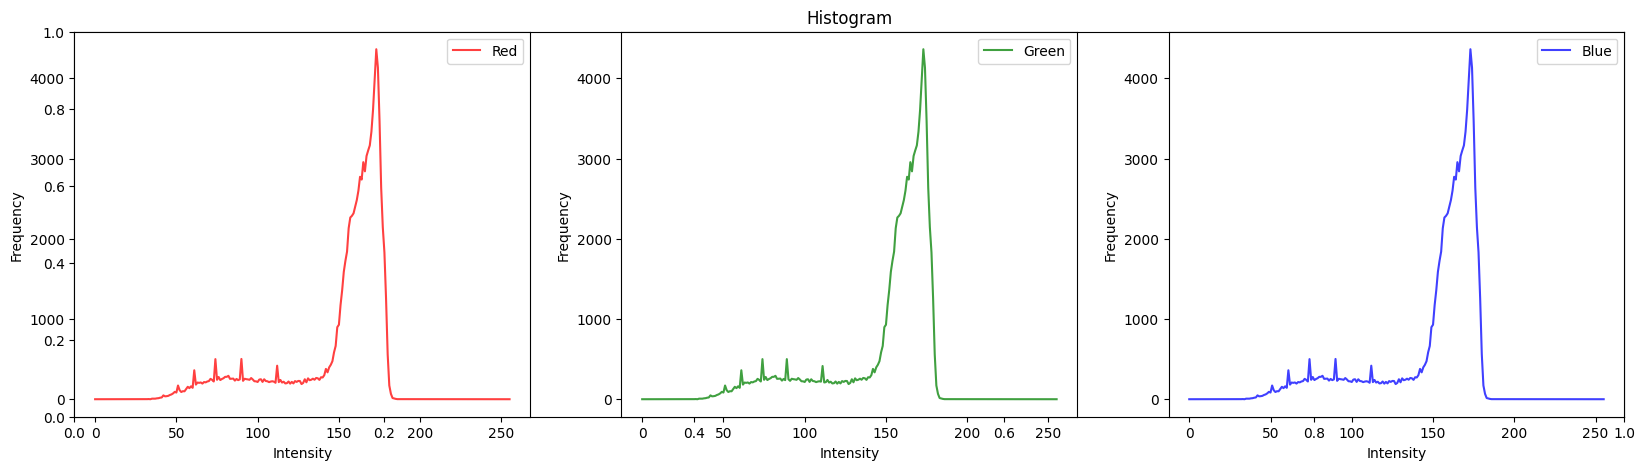

In [36]:
display_image(load_document_image('./historical-doc.png'), 'Document Image')
display_metadata('./historical-doc.png')
cv2_hist(load_document_image('./historical-doc.png'))

In [8]:
def preprocess_image(image: np.ndarray, aspect_ratio: float):
    steps = {}

    steps['original'] = image

    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    steps['gray'] = gray

    # normalize the image
    norm = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    steps['norm'] = norm

    # image scaling
    length, width = norm.shape
    factor_length = min(1, float(1024.0/ length))
    factor_width = (length * factor_length) / (width * aspect_ratio)
    size = int(length * factor_length), int(width * factor_width)
    scaled = cv2.resize(norm, size)
    steps['scaled'] = scaled

    # apply adaptive histogram equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(scaled)
    steps['equalized'] = equalized

    # denoising
    denoised = cv2.fastNlMeansDenoising(equalized, None, 10, 7, 21)
    steps['denoised'] = denoised

    # adaptive thresholding
    thresh = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, blockSize=25, C=15)
    steps['thresh'] = thresh

    # morphological operations
    kernel = np.ones((2,2), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    steps['morph'] = morph

    # connect nearby componeents horizontally   
    kernel = np.ones((1, 7), np.uint8)
    connected = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel)
    steps['connected'] = connected

    # vertical seperation
    kernel = np.ones((3, 1), np.uint8)
    separated = cv2.morphologyEx(connected, cv2.MORPH_OPEN, kernel)
    steps['separated'] = separated


    # display the preprocessed images
    plt.figure(figsize=(15, 75))
    for i, title in enumerate(steps.keys()):
        plt.subplot(6, 2, i + 1)
        plt.imshow(steps[title], cmap='gray')
        plt.title(title)
        plt.axis('off')
    
    plt.show()

    return connected


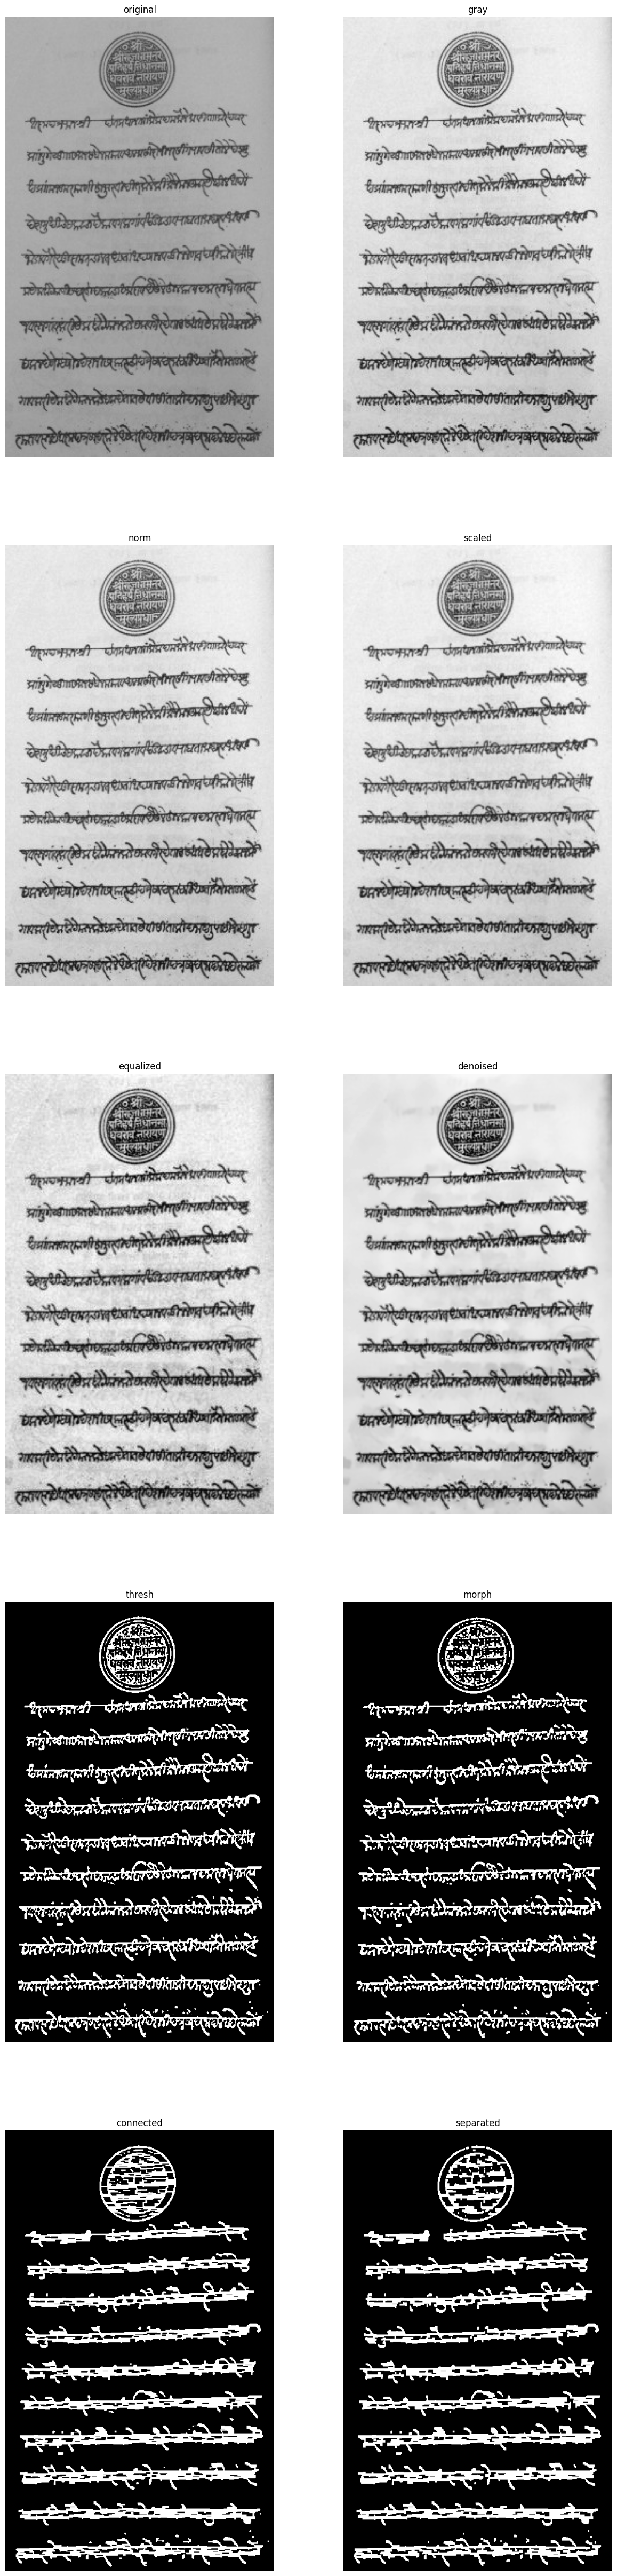

In [9]:
preprocessed_image = preprocess_image(load_document_image('./historical-doc.png'), 0.61)

#### Justifications:

1. **Grayscale Conversion:** Removes irrelevant color information, simplifying processing. No parameters are needed.

2. **Normalization:** Scales pixel intensities to the full 0-255 range, improving contrast for subsequent steps. No parameters are needed.

3. **Image Scaling:** Resizes the image to a manageable size (1024 pixels along the longest side) while maintaining the aspect ratio. Aspect ratio is maintained to avoid distorting the text lines.

4. **Adaptive Histogram Equalization (CLAHE)**: Enhances local contrast, improving the visibility of text lines and reducing uneven illumination effects. clipLimit=2.0 and tileGridSize=(8,8) were chosen empirically to balance contrast enhancement and noise amplification.

5. **Denoising (fastNlMeansDenoising)**: Reduces noise while preserving text line details. Parameters (10, 7, 21) control the denoising strength; they are experimentally determined to minimize noise without blurring text.

6. **Adaptive Thresholding:** Converts the image to binary, separating text from background. blockSize=25 and C=15 control the thresholding; these parameters were fine-tuned to accurately segment the text lines.

7. **Morphological Opening:** Removes small noise and artifacts, improving the cleanliness of the binary image. kernel = np.ones((2,2), np.uint8) – A small kernel is used to remove small artifacts without affecting the text.

8. **Horizontal Closing:** Connects broken horizontal segments of text lines, making them more continuous. kernel = np.ones((1, 7), np.uint8): Kernel size is chosen to connect gaps typical in handwriting, avoiding merging unrelated lines.

9. **Vertical Opening:** Separates closely spaced lines vertically. kernel = np.ones((3, 1), np.uint8): A small vertical kernel is used to separate connected components without affecting the vertical structure of each text line.

In [10]:
def save_text_line(original_image: np.ndarray, start: int, end: int, left: int, right: int, idx: int, output_folder: str):
    cropped_line = original_image[start:end, left:right]
    os.makedirs(output_folder, exist_ok=True)  
    file_path = os.path.join(output_folder, f"line_{idx + 1}.png")
    cv2.imwrite(file_path, cropped_line)
    print(f"Saved: {file_path}")

In [11]:
def save_seal(original_image: np.ndarray, seal_box: tuple, output_folder: str):
    os.makedirs(output_folder, exist_ok=True)  
    seal_x1, seal_y1, seal_x2, seal_y2 = seal_box
    cropped_seal = original_image[seal_y1:seal_y2, seal_x1:seal_x2]
    file_path = os.path.join(output_folder, "seal.png")
    cv2.imwrite(file_path, cropped_seal)
    print(f"Seal saved: {file_path}")

In [44]:
def detect_text_lines(image: np.ndarray, original_image: np.ndarray, output_folder: str):
    height, width = image.shape
    original_height, original_width = original_image.shape[:2]

    # Seal Detection via Contours
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    seal_box = None
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        if 0.8 < aspect_ratio < 1.2 and 50 < w < 200 and 50 < h < 200:  # Likely a circular seal
            seal_box = (x, y, x + w, y + h)
            break

    # Save the seal if detected
    if seal_box is not None:
        scaled_seal_box = (
            int((seal_box[0] / width) * original_width),
            int((seal_box[1] / height) * original_height),
            int((seal_box[2] / width) * original_width),
            int((seal_box[3] / height) * original_height),
        )
        save_seal(original_image, scaled_seal_box, output_folder)

    # Create mask to exclude seal region
    mask = np.ones_like(image)
    if seal_box is not None:
        seal_x1, seal_y1, seal_x2, seal_y2 = seal_box
        mask[seal_y1:seal_y2, seal_x1:seal_x2] = 0

    masked_image = image.copy() * mask

    # Calculate horizontal projection profile
    horizontal_profile = np.sum(masked_image, axis=1)
    kernel_size = 5
    smoothed_profile = np.convolve(
        horizontal_profile, np.ones(kernel_size) / kernel_size, mode="same"
    )

    # Find valleys (spaces between lines)
    valleys, _ = find_peaks(-smoothed_profile, distance=40, prominence=1000, height=-width * 0.9)
    # print(valleys)

    # Extract line regions
    line_regions = []
    if len(valleys) > 0:
        start = 0
        while start < height and horizontal_profile[start] == 0:
            start += 1
        line_regions.append((start, valleys[0]))
    for i in range(len(valleys) - 1):
        line_regions.append((valleys[i], valleys[i + 1]))
    if len(valleys) > 0:
        last_start = valleys[-1]
        end = height - 1
        while end > last_start and horizontal_profile[end] == 0:
            end -= 1
        line_regions.append((last_start, end))

    visualization = original_image.copy()
    # print(line_regions)

    # Draw bounding boxes for text lines on the original image
    for idx, (start, end) in enumerate(line_regions):
        region = masked_image[start:end, :]
        horizontal_proj = np.sum(region, axis=0)
        left_bound = 0
        right_bound = width - 1
        while left_bound < width and horizontal_proj[left_bound] == 0:
            left_bound += 1
        while right_bound > 0 and horizontal_proj[right_bound] == 0:
            right_bound -= 1

        padding_h = 5
        padding_v = 3
        left_bound = max(0, left_bound - padding_h)
        right_bound = min(width - 1, right_bound + padding_h)
        start = max(0, start - padding_v)
        end = min(height - 1, end + padding_v)

        if idx == 0 and seal_box is not None:
            seal_x1, seal_y1, seal_x2, seal_y2 = seal_box
            if start < seal_y2:
                start = seal_y2 + 5  

        scaled_start = int((start / height) * original_height)
        scaled_end = int((end / height) * original_height)
        scaled_left = int((left_bound / width) * original_width)
        scaled_right = int((right_bound / width) * original_width)

        save_text_line(original_image, scaled_start, scaled_end, scaled_left, scaled_right, idx, output_folder)
        cv2.rectangle(visualization, (scaled_left, scaled_start), (scaled_right, scaled_end), (0, 255, 0), 2)

    # Draw seal bounding box on the original image
    if seal_box is not None:
        seal_x1, seal_y1, seal_x2, seal_y2 = seal_box
        seal_x1 = int((seal_x1 / width) * original_width)
        seal_x2 = int((seal_x2 / width) * original_width)
        seal_y1 = int((seal_y1 / height) * original_height)
        seal_y2 = int((seal_y2 / height) * original_height)
        cv2.rectangle(
            visualization,
            (seal_x1, seal_y1),
            (seal_x2, seal_y2),
            (255, 0, 0),
            2,
        )

    return visualization
    

In [53]:
def display_results(original, processed, result):
    plt.figure(figsize=(12, 6))
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(132)
    plt.imshow(processed, cmap="gray")
    plt.title("Preprocessed Image")
    plt.axis("off")

    plt.subplot(133)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title("Text Line Detection on Original Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

Seal saved: ./output/seal.png
Saved: ./output/line_1.png
Saved: ./output/line_2.png
Saved: ./output/line_3.png
Saved: ./output/line_4.png
Saved: ./output/line_5.png
Saved: ./output/line_6.png
Saved: ./output/line_7.png
Saved: ./output/line_8.png
Saved: ./output/line_9.png
Saved: ./output/line_10.png


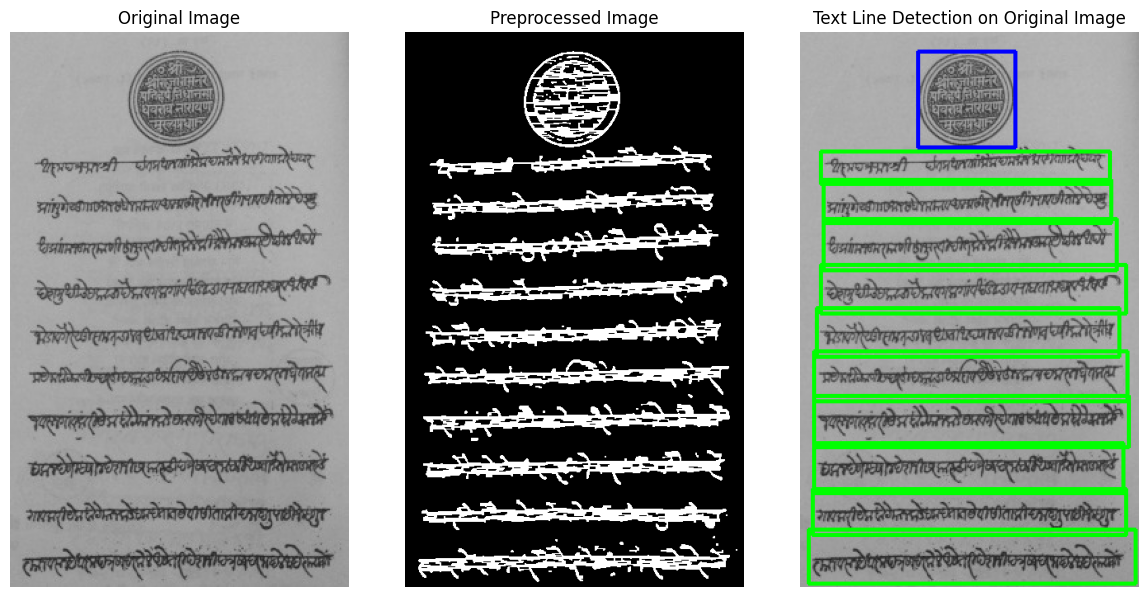

In [54]:
target_size = (673, 411)
image = load_document_image('./historical-doc.png')
resized_image = cv2.resize(image, target_size[:2], interpolation=cv2.INTER_AREA)
result_image = detect_text_lines(preprocessed_image, image, './output')
display_results(image, preprocessed_image, result_image)

#### Performance

The algorithm performs well for medium to high-resolution images with distinct text lines and a clearly separable seal. By leveraging horizontal projection and masking, it efficiently isolates and detects text lines while excluding the seal region.

#### Potential Failures

The algorithm may fail for small or low-resolution images where text lines are densely packed, as it relies heavily on clear valleys in the horizontal projection. It can also struggle with overlapping text and seal regions or when the seal shape deviates from expected circular characteristics. Additionally, highly curved or rotated text lines may not align with the horizontal projection method, leading to inaccurate detection.

In [55]:
# preprocess the seal.png
def preprocess_seal(image: np.ndarray):
    steps = {}

    steps['original'] = image

    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    steps['gray'] = gray

    # apply adaptive histogram equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(9,9))
    equalized = clahe.apply(gray)
    steps['equalized'] = equalized

    # denoising
    denoised = cv2.fastNlMeansDenoising(equalized, None, 10, 7, 21)
    steps['denoised'] = denoised

    # adaptive thresholding
    _, thresholded = cv2.threshold(denoised, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    steps['3. Thresholding'] = thresholded

    # morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1,1))
    morph = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel)
    steps['morph'] = morph

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,1))
    connected = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel, iterations=2)
    steps['connected'] = connected

    # vertical seperation
    kernel = np.ones((1, 1), np.uint8)
    separated = cv2.morphologyEx(connected, cv2.MORPH_OPEN, kernel, iterations = 2)
    steps['separated'] = cv2.bitwise_not(separated)


    # display the preprocessed images
    plt.figure(figsize=(10, 20))
    for i, title in enumerate(steps.keys()):
        plt.subplot(6, 3, i + 1)
        plt.imshow(steps[title], cmap='gray')
        plt.title(title)
        plt.axis('off') 
    plt.show()

    return cv2.bitwise_not(separated)

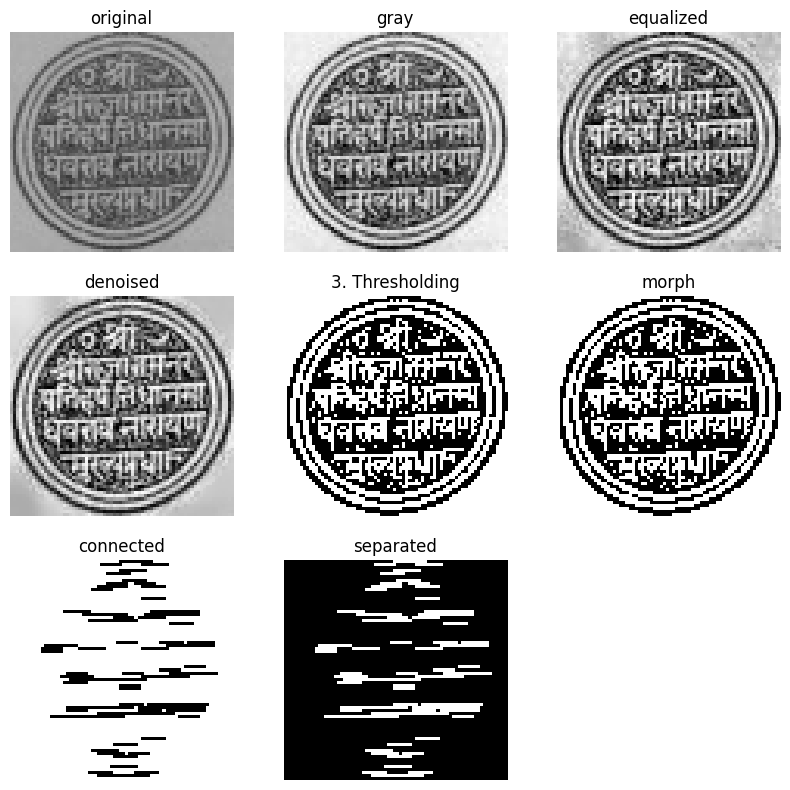

In [56]:
preprocessed_seal = preprocess_seal(load_document_image('./output/seal.png'))

#### Justification (difference in preprocessing)

**Normalization**: Skipped for the seal; already good contrast. Manuscript needed it due to uneven lighting.

**Scaling**: Not needed for the small seal image; Manuscript was large, requiring scaling for efficiency.

**CLAHE**: Slightly different grid size ((9,9) vs (8,8)) due to the seal's smaller size and resolution.

**Morphological Operations**: Simpler for the seal; manuscript required more extensive operations to connect broken lines and separate closely spaced ones.

**Thresholding**: Manual thresholding for the seal; Otsu's method was used for the manuscript (Otsu's was not always the best option for the seal image).

In [74]:
def detect_text_lines_seal(binary_image: np.ndarray, original_image: np.ndarray):
    hist = np.sum(binary_image == 0, axis=1)

    plt.plot(hist)
    plt.title("Row-wise Histogram")
    plt.show()

    # Find valleys in the histogram
    valleys, _ = find_peaks(-hist, prominence=15)
    print("Valleys (y-coordinates):", valleys)

    gray = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    # Detect the circle using HoughCircles
    detected_circles = cv2.HoughCircles(
        blurred, 
        cv2.HOUGH_GRADIENT, 
        dp=1.2, 
        minDist=30, 
        param1=50, 
        param2=30, 
        minRadius=0, 
        maxRadius=0
    )
    
    detected_circles = np.uint16(np.around(detected_circles))
    a, b, r = detected_circles[0][0]
    print(f"Circle center: ({a}, {b}), Radius: {r}")

    # Visualize the detected circle
    circle_visualization = original_image.copy()
    cv2.circle(circle_visualization, (a, b), r, (0, 255, 0), 1)  # Draw circumference
    cv2.circle(circle_visualization, (a, b), 1, (0, 0, 255), 2)  # Draw center
    plt.imshow(circle_visualization)
    plt.title("Detected Circle")
    plt.show()

    # Find points of intersection between the circle and histogram valleys
    points = {}
    for y in valleys:
        if abs(y - b) <= r:
            x1 = math.sqrt(r ** 2 - (y - b) ** 2) + a
            x2 = -math.sqrt(r ** 2 - (y - b) ** 2) + a
            points[y] = [x1, x2]

    # Generate bounding boxes for regions between consecutive valleys
    bounding_boxes = []
    sorted_valleys = sorted(points.keys())
    for i in range(len(sorted_valleys) - 1):
        y1, y2 = sorted_valleys[i], sorted_valleys[i + 1]
        x1, x2 = points[y1]
        x3, x4 = points[y2]
        bounding_boxes.append((max(x1, x3), y1, min(x2, x4), y2))

    bounding_boxes_seal = []                        
    visualization = original_image.copy()
    for x1, y1, x2, y2 in bounding_boxes:
        cv2.rectangle(visualization, (int(x1) - 4, y1), (int(x2) + 4, y2), (0, 255, 0), 1)
        bounding_boxes_seal.append((int(x2), y1, (int(x1) - int(x2)), (y2 - y1)))

    plt.figure(figsize=(5,5))
    plt.imshow(visualization)
    plt.axis('off')
    plt.title("Bounding Boxes")
    plt.show()

    return bounding_boxes_seal

In [75]:
def save_into_folder(original_image: np.ndarray, bounding_boxes: list, output_folder: str):
    os.makedirs(output_folder, exist_ok=True)
    height, width = original_image.shape[:2]

    for idx, (x1, y1, width, height) in enumerate(bounding_boxes):
        x2 = x1 + width
        y2 = y1 + height
        x1, y1 = int(max(0, x1)), int(max(0, y1))
        x2, y2 = int(min(original_image.shape[1], x2)), int(min(original_image.shape[0], y2))

        cropped = original_image[y1:y2, x1:x2]

        output_path = os.path.join(output_folder, f"circle_line_{idx + 1}.png")
        cv2.imwrite(output_path, cropped)
        print(f"Saved: {output_path}")

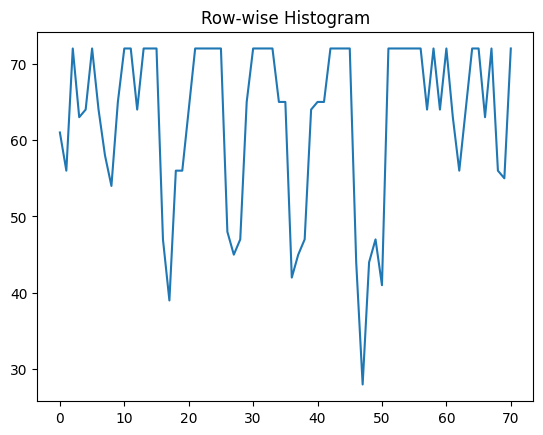

Valleys (y-coordinates): [ 8 17 27 36 47 62 69]
Circle center: (35, 35), Radius: 29


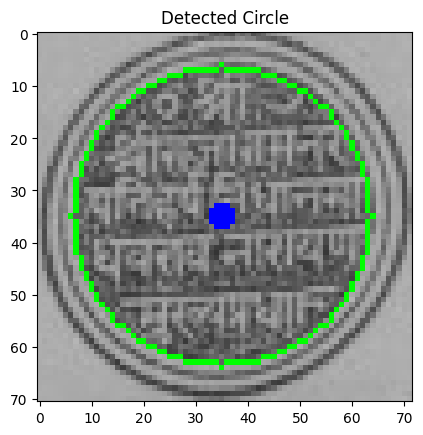

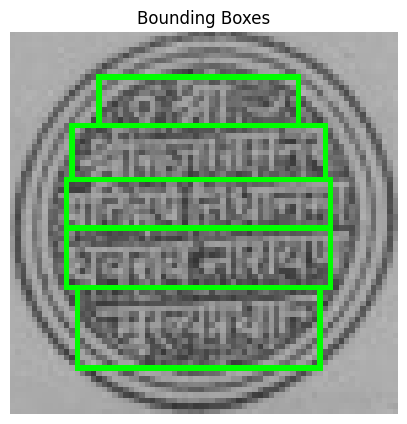

Saved: ./output_seal/circle_line_1.png
Saved: ./output_seal/circle_line_2.png
Saved: ./output_seal/circle_line_3.png
Saved: ./output_seal/circle_line_4.png
Saved: ./output_seal/circle_line_5.png


In [76]:
bounding_boxes_seal = detect_text_lines_seal(preprocessed_seal, load_document_image('./output/seal.png'))  
save_into_folder(load_document_image('./output/seal.png'), bounding_boxes_seal, './output_seal')

#### Modifications made from the previous algorithm

**Performance Difference**

The previous algorithm primarily relies on a horizontal projection profile, making it suitable for larger images with clear line spacing. In contrast, the modified algorithm leverages row-wise histograms and circle-seal detection, offering better precision in small images with dense or tightly packed text.

**Seal Handling**

While the earlier method masks the seal region based on contours, the new approach uses the Hough Circle Transform to detect seals more accurately, even in low-resolution or complex cases. This ensures better integration of seal boundaries when defining text regions.

**Small Image Handling**

The initial algorithm struggles with smaller images due to its reliance on prominent spacing between text lines. The updated method, however, combines histogram valleys and seal boundaries to perform well in detecting lines even in compact or low-spacing scenarios.